### Predicting House Prices

In [1]:
#importing the libraries

from __future__ import absolute_import, division, print_function, unicode_literals
import category_encoders as ce
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import math
colours = sns.set_palette('pastel')

In [2]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.1.0


In [86]:
def plot_model(model):
    test_predictions = model.predict(normed_x).flatten()
    plt.figure(figsize=[7,7])
    plt.scatter(saleprice, saleprice,s=area, c='r', marker='.', alpha=0.5)
    plt.scatter(saleprice, test_predictions,s=area, c=area, alpha=0.35)
    plt.xlabel('True Values [SalePrice]',color='r')
    plt.ylabel('Predictions [SalePrice]',color='g')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])
    _ = plt.plot()
    #plt.savefig('decision_plot.svg')

### Preprocessing Data

In [4]:
#import the datasets
trn_csv = pd.read_csv('datasets/basic_regression_train.csv')
tst_csv = pd.read_csv('datasets/basic_regression_test.csv')

In [5]:
#create dataframes to store the imported data to avoid making changes to it
train = trn_csv.copy()
test = tst_csv.copy()
print(train.shape, test.shape)

(1460, 81) (1459, 80)


In [6]:
train['SalePrice'].corr(train['LotArea'])

0.26384335387140556

In [7]:
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [8]:
train.tail(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


### Exploratory Data Analysis

In [9]:
# Check for null entries in each column. These will have to be addressed during preprocessing
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [10]:
train.isnull().mean()

Id               0.000000
MSSubClass       0.000000
MSZoning         0.000000
LotFrontage      0.177397
LotArea          0.000000
                   ...   
MoSold           0.000000
YrSold           0.000000
SaleType         0.000000
SaleCondition    0.000000
SalePrice        0.000000
Length: 81, dtype: float64

In [11]:
# Remove all the features having more than 50% null values
train = train[train.columns[train.isnull().mean() < 0.5]]
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500


In [12]:
#Missing Values and Imputation
train.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 77, dtype: int64

Text(0.5, 1.0, 'Missing Values')

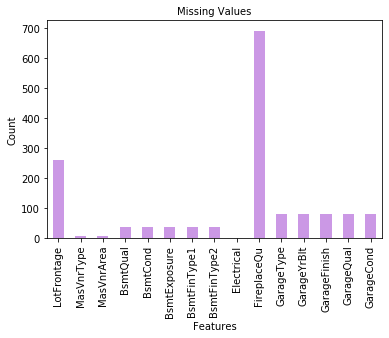

In [13]:
#Plotting Missing Values
missingvalues = train.isnull().sum()
missingvalues = missingvalues[missingvalues > 0]
missingvalues.plot.bar(color='darkorchid', alpha=0.5)
plt.xlabel('Features',fontsize=10)
plt.ylabel('Count',fontsize = 10)
plt.title('Missing Values', fontsize=10)

In [14]:
#Columns with missing values
missingvalues.head(2)

LotFrontage    259
MasVnrType       8
dtype: int64

### Pop out important columns regardless of correlation

In [15]:
# Remove the encoded columns, to be readded later
hood = train.pop('Neighborhood')
style = train.pop('HouseStyle')
kitchen = train.pop('KitchenQual')
building = train.pop('BldgType')
overall = train.pop('OverallCond')

### Drop columns with Low Correlation

In [16]:
#find the columns that will not be dropped
kept = train.copy()

### Feature Encoding
---
#### Encoding with cat.codes

In [17]:
# Uses ordinal encoding to encode string data
def encode_df(frame):
    columns = frame.select_dtypes(include=['object']).columns
    i = 0
    j = int(len(columns))
    for i in range(0,j):
        frame[columns[i]] = frame[columns[i]].astype('category')
        frame[columns[i]] = frame[columns[i]].cat.codes
        i = i + 1
    return frame

In [18]:
encode_df(kept)
kept.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,3,3,0,4,...,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,3,3,0,2,...,0,0,0,0,0,5,2007,8,4,181500


In [19]:
# Drops columns with a correlation to SalePrice less than "cut", in this case 0.5
def drop_corr(frame):
    #cut = float(input('Enter the float value for the cutoff: '))
    cut = 0.5
    index = frame.columns
    i = 1
    u = len(index)
    dropped = 0
    kept = 0

    while i < u:
        if abs(frame['SalePrice'].corr(frame[index[i]])) < cut:
            frame.pop(index[i])
            dropped = dropped + 1
            print('.', end='')
        else:
            print('^', end='')
            kept = kept + 1
        i = i + 1
    print('\nCompleted.')
    print('\nDropped = ', dropped)
    print('\nKept = ', kept)
    print('\n',frame.shape)
    return frame

In [20]:
drop_corr(kept)
kept.head(2)

............^^^......^..........^....^..^..^...^......^^..............^
Completed.

Dropped =  59

Kept =  12

 (1460, 13)


,Id,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
0,1,7,2003,2003,2,856,856,1710,2,8,2,548,208500
1,2,6,1976,1976,3,1262,1262,1262,2,6,2,460,181500


In [21]:
# select the columns that will be used for the prediction
get_columns = kept.columns
get_columns

Index(['Id', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
       'GarageCars', 'GarageArea', 'SalePrice'],
      dtype='object')

In [22]:
# select the columns that will be used for the prediction
labels = train[get_columns]
labels.head(2)

,Id,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
0,1,7,2003,2003,Gd,856,856,1710,2,8,2,548,208500
1,2,6,1976,1976,TA,1262,1262,1262,2,6,2,460,181500


In [23]:
# Return the popped columns to the labels dataframe.
#labels = labels.copy()
labels['Neighborhood'] = hood
labels['HouseStyle'] = style
labels['KitchenQual'] = kitchen
labels['BldgType'] = building
labels['OverallCond'] = overall
labels.head(1)

/home/todd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/todd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/todd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,Id,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,Neighborhood,HouseStyle,KitchenQual,BldgType,OverallCond
0,1,7,2003,2003,Gd,856,856,1710,2,8,2,548,208500,CollgCr,2Story,Gd,1Fam,5


In [24]:
labels.columns

Index(['Id', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
       'GarageCars', 'GarageArea', 'SalePrice', 'Neighborhood', 'HouseStyle',
       'KitchenQual', 'BldgType', 'OverallCond'],
      dtype='object')

In [25]:
#list the unique values of each categorical column
def get_unique(frame):
    columns = frame.select_dtypes(include=['object']).columns
    i = 0
    for column in columns:
        print(frame[columns[i]].unique())
        i = i + 1
get_unique(labels)

['Gd' 'TA' 'Ex' 'Fa']
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
['Gd' 'TA' 'Ex' 'Fa']
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']


---
### Ordinal Encoding
---


In [26]:
ord1 = [{'col': 'ExterQual', 'mapping':{'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}}]
ord2 = [{'col': 'KitchenQual', 'mapping':{'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}}]
ord3 = [{'col': 'BldgType', 'mapping':{'Twnhs': 1, 'TwnhsE': 2, 'Duplex': 3, '2fmCon': 4, '1Fam': 5}}]
ord4 = [{'col': 'HouseStyle', 'mapping':{'SFoyer': 1, 'SLvl': 2, '1.5Unf': 3, '1.5Fin': 4,
                                    '1Story': 5, '2Story': 6, '2.5Unf': 7, '2.5Fin': 8}}]

In [27]:
def ordinal_encode(frame,col):
    encoder = ce.OrdinalEncoder(mapping = col, return_df = True)
    frame = encoder.fit_transform(frame)
    return frame

Now let's organize the neighborhood data to see which ones have the most expensive homes

In [28]:
a = pd.DataFrame(np.array([labels.groupby(['Neighborhood'])['SalePrice'].aggregate(np.max).sort_values()])).T
b = labels.groupby(['Neighborhood'])['SalePrice'].aggregate(np.max).sort_values()
c = pd.DataFrame(np.array([b.index])).T
d = a
d[1] = c
x = d[1]
y = d[0]

<BarContainer object of 25 artists>

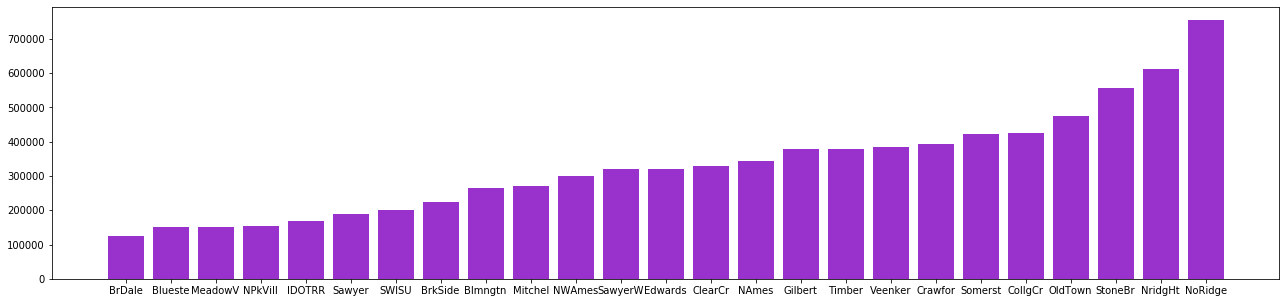

In [29]:
# plot the neighbourhoods

plt.figure(figsize=[22.0,5.0])
plt.bar(x,y, color = 'darkorchid')

In [30]:
ord5 = [{'col': 'Neighborhood', 'mapping':{'BrDale': 1, 'Blueste': 2, 'MeadowV': 3, 'NPkVill': 4,
                                           'IDOTRR': 5, 'Sawyer': 6, 'SWISU': 7, 'BrkSide': 8,
                                           'Blmngtn': 9, 'Mitchel': 10, 'NWAmes': 11, 'SawyerW': 12,
                                           'Edwards': 13, 'ClearCr': 14, 'NAmes': 15, 'Gilbert': 16,
                                           'Timber': 17, 'Veenker': 18, 'Crawfor': 19, 'Somerst': 20,
                                           'CollgCr': 21, 'OldTown': 22, 'StoneBr': 23, 'NridgHt': 24,
                                           'NoRidge': 25}}]

In [31]:
labels = ordinal_encode(labels,ord1)
labels = ordinal_encode(labels,ord2)
labels = ordinal_encode(labels,ord3)
labels = ordinal_encode(labels,ord4)
labels = ordinal_encode(labels,ord5)
labels.head(2)

,Id,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,Neighborhood,HouseStyle,KitchenQual,BldgType,OverallCond
0,1,7,2003,2003,3,856,856,1710,2,8,2,548,208500,21,6,3,5,5
1,2,6,1976,1976,2,1262,1262,1262,2,6,2,460,181500,18,5,2,5,8


In [32]:
# Remove id column so it doesn't interfere with training.
id_num = labels.pop('Id')

In [33]:
# For reference, create a table displaying the correlation values of all kept columns, both to SalePrice and each other.
labels.corr()

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,Neighborhood,HouseStyle,KitchenQual,BldgType,OverallCond
OverallQual,1.000000,0.572323,0.550684,0.726278,0.537808,0.476224,0.593007,0.550600,0.427452,0.600671,0.562022,0.790982,0.470148,0.235676,0.673331,-0.022988,-0.091932
YearBuilt,0.572323,1.000000,0.592855,0.598160,0.391452,0.281986,0.199010,0.468271,0.095589,0.537850,0.478954,0.522897,0.290402,0.116173,0.530165,-0.197934,-0.375983
YearRemodAdd,0.550684,0.592855,1.000000,0.587318,0.291066,0.240379,0.287389,0.439046,0.191740,0.420622,0.371600,0.507101,0.357268,0.189131,0.625316,-0.082713,0.073741
ExterQual,0.726278,0.598160,0.587318,1.000000,0.470580,0.397835,0.435986,0.483949,0.297903,0.526390,0.495778,0.682639,0.480711,0.214327,0.716122,-0.074940,-0.138942
TotalBsmtSF,0.537808,0.391452,0.291066,0.470580,1.000000,0.819530,0.454868,0.323722,0.285573,0.434585,0.486665,0.613581,0.291381,0.053473,0.432630,0.081380,-0.171098
1stFlrSF,0.476224,0.281986,0.240379,0.397835,0.819530,1.000000,0.566024,0.380637,0.409516,0.439317,0.489782,0.605852,0.254220,-0.012469,0.387027,0.106377,-0.144203
GrLivArea,0.593007,0.199010,0.287389,0.435986,0.454868,0.566024,1.000000,0.630012,0.825489,0.467247,0.468997,0.708624,0.318742,0.365447,0.420563,0.126722,-0.079686
FullBath,0.550600,0.468271,0.439046,0.483949,0.323722,0.380637,0.630012,1.000000,0.554784,0.469672,0.405656,0.560664,0.310841,0.294226,0.434648,-0.070202,-0.194149
TotRmsAbvGrd,0.427452,0.095589,0.191740,0.297903,0.285573,0.409516,0.825489,0.554784,1.000000,0.362289,0.337822,0.533723,0.220432,0.337493,0.287279,0.181233,-0.057583
GarageCars,0.600671,0.537850,0.420622,0.526390,0.434585,0.439317,0.467247,0.469672,0.362289,1.000000,0.882475,0.640409,0.379763,0.173928,0.509810,0.020490,-0.185758


---
### Visualization
---

In [34]:
#Summarize target value (SalePrice) using describe ()
labels.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

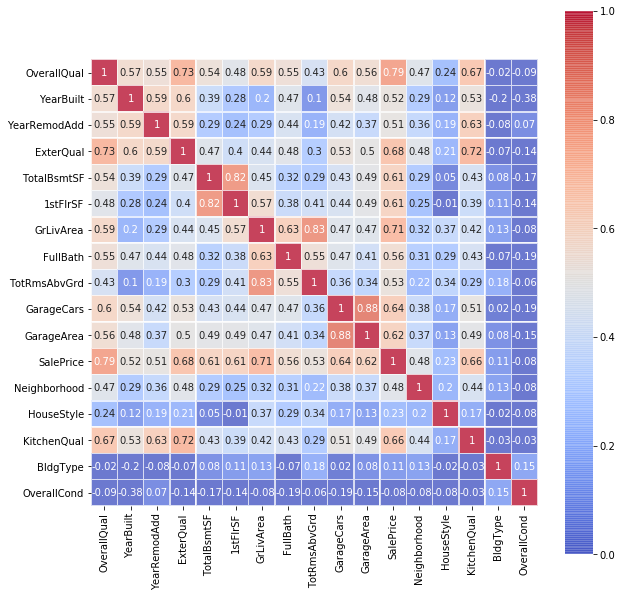

In [35]:
#Plotting a heatmap
plt.subplots(figsize=(10,10))
correlation_matrix = labels.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap = 'coolwarm',vmin=0, vmax=1, linewidths=.5, square=True, alpha=0.75)

In [36]:
#Plotting a pairplot
#sns.pairplot(labels[['SalePrice','OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea', 'KitchenQual']], diag_kind='kde', hue = 'OverallQual', palette='coolwarm')

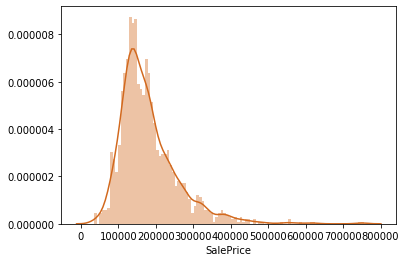

In [37]:
#Plot the distribution of SalePrice
sns.distplot(labels.SalePrice,bins=100,color='chocolate')

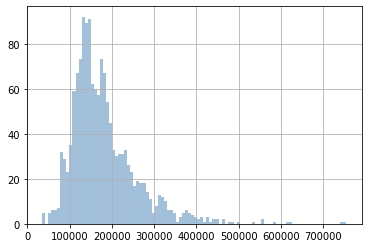

In [38]:
#Plot the histogram of numerical values (Hint: df.hist())
labels.SalePrice.hist(bins=100,color='steelblue',alpha=0.5)

In [39]:
# Look at the description of the input columns
x_stats = labels.describe()
x_stats.pop('SalePrice')
x_stats = x_stats.transpose()
x_stats

,count,mean,std,min,25%,50%,75%,max
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
ExterQual,1460.0,2.395890,0.574280,1.0,2.00,2.0,3.00,4.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.50,1464.0,1776.75,5642.0
FullBath,1460.0,1.565068,0.550916,0.0,1.00,2.0,2.00,3.0
TotRmsAbvGrd,1460.0,6.517808,1.625393,2.0,5.00,6.0,7.00,14.0
GarageCars,1460.0,1.767123,0.747315,0.0,1.00,2.0,2.00,4.0


In [40]:
# Remove SalePrice, the target value, from the training dataframe
saleprice = labels.pop('SalePrice')

In [41]:
# Normalize the dataframe

def norm(x):
    return (x - x_stats['mean']) / x_stats['std']

normed_x = norm(labels)

normed_x.head(2)

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,Neighborhood,HouseStyle,KitchenQual,BldgType,OverallCond
0,0.651256,1.050634,0.878367,1.051942,-0.459145,-0.793162,0.370207,0.78947,0.911897,0.311618,0.35088,0.947495,0.885766,0.735742,0.416176,-0.517023
1,-0.071812,0.156680,-0.429430,-0.689368,0.466305,0.257052,-0.482347,0.78947,-0.318574,0.311618,-0.06071,0.440343,0.020158,-0.770827,0.416176,2.178881


In [42]:
# Ensure no null values are in the training set
normed_x.isna().sum()

OverallQual     0
YearBuilt       0
YearRemodAdd    0
ExterQual       0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
GarageCars      0
GarageArea      0
Neighborhood    0
HouseStyle      0
KitchenQual     0
BldgType        0
OverallCond     0
dtype: int64

In [43]:
normed_x.fillna(0)
normed_x.tail(1)

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,Neighborhood,HouseStyle,KitchenQual,BldgType,OverallCond
1459,-0.794879,-0.207523,-0.962236,1.051942,0.452629,0.241532,-0.493765,-1.025689,-0.318574,-1.026506,-0.921308,-0.404911,0.020158,-0.770827,0.416176,0.381612


In [44]:
normed_x.head()

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,Neighborhood,HouseStyle,KitchenQual,BldgType,OverallCond
0,0.651256,1.050634,0.878367,1.051942,-0.459145,-0.793162,0.370207,0.789470,0.911897,0.311618,0.350880,0.947495,0.885766,0.735742,0.416176,-0.517023
1,-0.071812,0.156680,-0.429430,-0.689368,0.466305,0.257052,-0.482347,0.789470,-0.318574,0.311618,-0.060710,0.440343,0.020158,-0.770827,0.416176,2.178881
2,0.651256,0.984415,0.829930,1.051942,-0.313261,-0.627611,0.514836,0.789470,-0.318574,0.311618,0.631510,0.947495,0.885766,0.735742,0.416176,-0.517023
3,0.651256,-1.862993,-0.720051,-0.689368,-0.687089,-0.521555,0.383528,-1.025689,0.296662,1.649742,0.790533,0.609393,0.885766,0.735742,0.416176,-0.517023
4,1.374324,0.951306,0.733056,1.051942,0.199611,-0.045596,1.298881,0.789470,1.527133,1.649742,1.697903,1.623698,0.885766,0.735742,0.416176,-0.517023


In [45]:
dataset = pd.concat([normed_x, saleprice], axis=1)#, ignore_index=False)

In [46]:
dataset

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,Neighborhood,HouseStyle,KitchenQual,BldgType,OverallCond,SalePrice
0,0.651256,1.050634,0.878367,1.051942,-0.459145,-0.793162,0.370207,0.789470,0.911897,0.311618,0.350880,0.947495,0.885766,0.735742,0.416176,-0.517023,208500
1,-0.071812,0.156680,-0.429430,-0.689368,0.466305,0.257052,-0.482347,0.789470,-0.318574,0.311618,-0.060710,0.440343,0.020158,-0.770827,0.416176,2.178881,181500
2,0.651256,0.984415,0.829930,1.051942,-0.313261,-0.627611,0.514836,0.789470,-0.318574,0.311618,0.631510,0.947495,0.885766,0.735742,0.416176,-0.517023,223500
3,0.651256,-1.862993,-0.720051,-0.689368,-0.687089,-0.521555,0.383528,-1.025689,0.296662,1.649742,0.790533,0.609393,0.885766,0.735742,0.416176,-0.517023,140000
4,1.374324,0.951306,0.733056,1.051942,0.199611,-0.045596,1.298881,0.789470,1.527133,1.649742,1.697903,1.623698,0.885766,0.735742,0.416176,-0.517023,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.071812,0.918196,0.733056,-0.689368,-0.238040,-0.542249,0.250316,0.789470,0.296662,0.311618,-0.060710,0.102241,0.885766,-0.770827,0.416176,-0.517023,175000
1456,-0.071812,0.222899,0.151813,-0.689368,1.104547,2.354894,1.061003,0.789470,0.296662,0.311618,0.126376,-0.743013,0.020158,-0.770827,0.416176,0.381612,210000
1457,0.651256,-1.002149,1.023678,2.793251,0.215567,0.065634,1.569110,0.789470,1.527133,-1.026506,-1.033560,0.609393,0.885766,0.735742,0.416176,3.077516,266500
1458,-0.794879,-0.704164,0.539309,-0.689368,0.046889,-0.218907,-0.832502,-1.025689,-0.933810,-1.026506,-1.089686,-0.066810,0.020158,0.735742,0.416176,0.381612,142125


In [47]:
dataset.to_csv('home_prices.csv',header=True,index=False)

---
## Models
---


In [48]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test  = train_test_split(normed_x, saleprice, test_size = 1/3, random_state = 42, shuffle=True)

In [49]:
axis = np.arange(0,1460)
axis.shape

(1460,)

### Linear Regression Model

In [50]:
#Linear Regression Model
def linearRegression():
    model = LinearRegression()
    model.fit(X_train, Y_train)
    return model

linear_mod = linearRegression()

print('Linear Regression Model')

print('\nRMSE: ', sqrt(mean_squared_error(Y_test,linear_mod.predict(X_test))))
print('\nScore',round(linear_mod.score(X_test, Y_test)*100,2))

Linear Regression Model

RMSE:  36778.89641515409

Score 81.42


In [51]:
hood

0       CollgCr
1       Veenker
2       CollgCr
3       Crawfor
4       NoRidge
         ...   
1455    Gilbert
1456     NWAmes
1457    Crawfor
1458      NAmes
1459    Edwards
Name: Neighborhood, Length: 1460, dtype: object

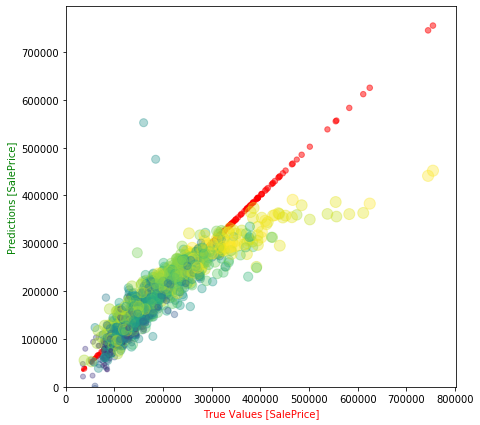

In [87]:
plot_mod = plot_model(linear_mod)

### Decision Tree Regression Model

In [53]:
#DecisionTreeRegressor
def decisionTree():
    model = DecisionTreeRegressor(criterion='mse', splitter='random', max_depth=8, max_features='log2')
    model.fit(X_train, Y_train)
    return model

decision_mod = decisionTree()

print('Decision Tree Regression Model')

print('\nRMSE: ', sqrt(mean_squared_error(Y_test, decision_mod.predict(X_test))))
print('\nScore',round(decision_mod.score(X_test, Y_test)*100,2))

Decision Tree Regression Model

RMSE:  44379.40078333792

Score 72.94


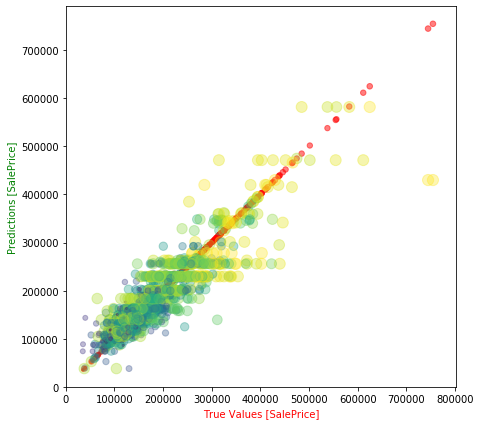

In [88]:
plot_mod = plot_model(decision_mod)

### Random Forest Regression Model

In [55]:
#Random Forest Regression
def forestRegression():
    model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    model.fit(X_train, Y_train)
    return model
    
forest_mod = forestRegression()

print('Random Forest Regression Model')

print('\nRMSE: ', sqrt(mean_squared_error(Y_test,forest_mod.predict(X_test))))
print('\nScore',round(forest_mod.score(X_test, Y_test)*100,2))

Random Forest Regression Model

RMSE:  29662.630133573613

Score 87.91


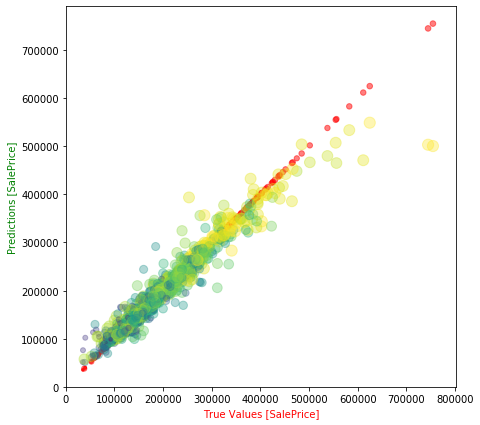

In [89]:
plot_mod = plot_model(forest_mod)

### TensorFlow model using keras.Sequential()

In [57]:
def kerasSequential():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(labels.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    
    return model
keras_mod = kerasSequential()

keras_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,313
Trainable params: 5,313
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = keras_mod.fit(normed_x,
                    saleprice,
                    epochs=EPOCHS,
                    batch_size=128,
                    validation_split = 0.2,
                    verbose=0,
                    callbacks=[PrintDot()])
print('\nCompleted.')


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [59]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [60]:
hist.describe()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
count,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1000.000000
mean,8.151706e+09,60307.447111,8.151706e+09,9.519971e+09,62749.545594,9.519971e+09,499.500000
std,1.174167e+10,51795.763974,1.174167e+10,1.158427e+10,51341.073120,1.158427e+10,288.819436
min,9.157670e+08,19766.791016,9.157670e+08,2.086699e+09,22176.585938,2.086699e+09,0.000000
25%,1.135351e+09,23282.005859,1.135351e+09,2.307253e+09,25745.250000,2.307253e+09,249.750000
50%,2.661997e+09,37780.658203,2.661997e+09,4.271648e+09,40660.437500,4.271648e+09,499.500000
75%,6.435872e+09,63644.172852,6.435873e+09,8.656175e+09,66691.380859,8.656175e+09,749.250000
max,3.881904e+10,180589.281250,3.881905e+10,3.991767e+10,182242.671875,3.991767e+10,999.000000


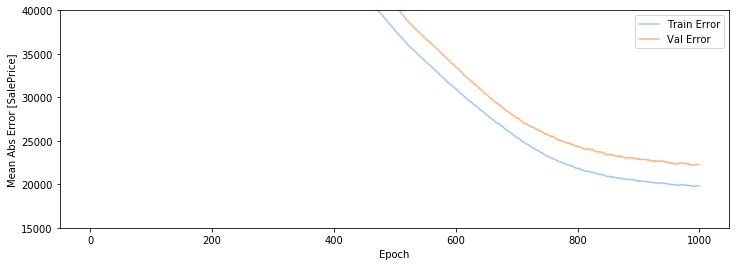

In [61]:
# Compare training and valudation error over epochs of training, to avoid overfitting issues
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=[12.0,4.0])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [SalePrice]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([15000,40000])
    plt.legend()


plot_history(history)

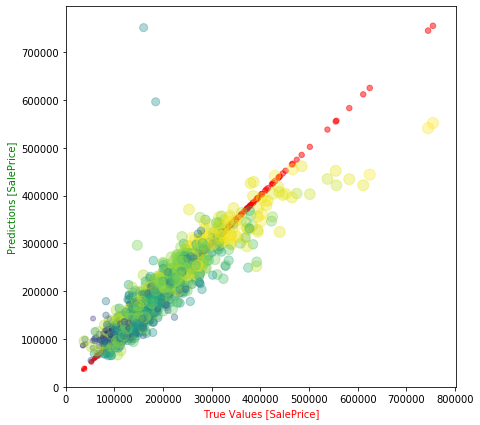

In [90]:
plot_mod = plot_model(keras_mod)

In [63]:
print(len(train))

1460


In [64]:
features = trn_csv[labels.columns]

In [65]:
# Verify the neural net on an arbitrary row of the training data
train_rows = 1400
train_cols = len(labels.columns) - 1
k = 0
x = float(labels.iloc[train_rows,train_cols])
y_actual = [train.SalePrice.iloc[train_rows]]
y = normed_x.iloc[train_rows].tolist()
value = keras_mod.predict([y]).flatten().round()
while k <= train_cols:
    print(features.columns[k],':', features.iloc[train_rows,k])
    k += 1

OverallQual : 6
YearBuilt : 1929
YearRemodAdd : 1950
ExterQual : TA
TotalBsmtSF : 862
1stFlrSF : 950
GrLivArea : 1158
FullBath : 1
TotRmsAbvGrd : 5
GarageCars : 1
GarageArea : 208
Neighborhood : BrkSide
HouseStyle : 1.5Fin
KitchenQual : TA
BldgType : 1Fam
OverallCond : 7


In [66]:
from sklearn.metrics import r2_score

print('\nKeras Sequential Model')
print('\n\nThe actual sale price of the home is: $'+str(train.SalePrice.iloc[k])+'.00')
print('\nThe INFERED price of the home is :    $'+str(value[0])+str(0))

print('\nRMSE: ', sqrt(mean_squared_error(y_actual,value)))
print('\nScore: ', round(r2_score(Y_test, keras_mod.predict(X_test))*100,2))


Keras Sequential Model


The actual sale price of the home is: $149000.00

The INFERED price of the home is :    $135588.00

RMSE:  15588.0

Score:  87.39


---
### Predict Price Using Test Dataset
---

In [67]:
test_y = test[features.columns]

In [68]:
encode_df(test_y)
test_y.head(2)

/home/todd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/todd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,Neighborhood,HouseStyle,KitchenQual,BldgType,OverallCond
0,5,1961,1961,3,882.0,896,896,1,5,1.0,730.0,12,2,3,0,6
1,6,1958,1958,3,1329.0,1329,1329,1,6,1.0,312.0,12,2,2,0,6


In [69]:
normed_test = norm(test_y)

In [70]:
print(len(test_y))

1459


In [71]:
m = int(input('Enter a Record number - between 0 and 1458 - from the dataset,\nto generate a house price estimate: '))
n = len(test_y.columns) - 1
o = 0
p = normed_test.iloc[m].tolist()
value1 = forest_mod.predict([p]).flatten().round()
value2 = keras_mod.predict([p]).flatten().round()
value3 = linear_mod.predict([p]).flatten().round()
value4 = decision_mod.predict([p]).flatten().round()
print('\n')
while o <= n:
    print(test_y.columns[o],':', test_y.iloc[m,o])
    o += 1
print('\nThe estimated price of the home using;')
print('\nRandom Forest is:              $'+str(value1[0])+str(0))
print('\nKERAS Sequential is:           $'+str(value2[0])+str(0))
print('\nLinear Regression is:          $'+str(value3[0])+str(0))
print('\nDecision Tree Regression is:   $'+str(value4[0])+str(0))

Enter a Record number - between 0 and 1458 - from the dataset,
to generate a house price estimate: 567


OverallQual : 7
YearBuilt : 2007
YearRemodAdd : 2007
ExterQual : 2
TotalBsmtSF : 689.0
1stFlrSF : 703
GrLivArea : 1392
FullBath : 2
TotRmsAbvGrd : 5
GarageCars : 2.0
GarageArea : 540.0
Neighborhood : 21
HouseStyle : 4
KitchenQual : 2
BldgType : 4
OverallCond : 5

The estimated price of the home using;

Random Forest is:              $173026.00

KERAS Sequential is:           $163254.00

Linear Regression is:          $179252.00

Decision Tree Regression is:   $163310.00


---
- OverallQual is 1(Very Poor) to 10(Very Excellent)
- HouseStyle is 1 for One story, 2-3 for One and half story, 4 Two Story, 5-6 Two and one half story, 7-8 Split Foyer
- KitchenQual is -1 to 3
- ExterQual is 0 to 3
- BldgType is 0 to 5
---

In [72]:
print('Enter required values to generate a house price estimate: ')
arr = []
arr_columns = test_y.columns
for c in arr_columns:
    row = int(input('%s:' % c))
    arr.append(row)
estimate = norm(arr).tolist()
value1 = forest_mod.predict([estimate]).flatten().round()
value2 = keras_mod.predict([estimate]).flatten().round()
value3 = linear_mod.predict([estimate]).flatten().round()
value4 = decision_mod.predict([estimate]).flatten().round()
print('\n')
while o <= n:
    print(test_y.columns[o],':', test_y.iloc[m,o])
    o += 1
print('\nThe estimated price of the home using;')
print('\nRandom Forest is:              $'+str(value1[0])+str(0))
print('\nKERAS Sequential is:           $'+str(value2[0])+str(0))
print('\nLinear Regression is:          $'+str(value3[0])+str(0))
print('\nDecision Tree Regression is:   $'+str(value4[0])+str(0))

Enter required values to generate a house price estimate: 
OverallQual:5
YearBuilt:2007
YearRemodAdd:2011
ExterQual:1
TotalBsmtSF:5
1stFlrSF:5
GrLivArea:5
FullBath:5
TotRmsAbvGrd:5
GarageCars:5
GarageArea:5
Neighborhood:5
HouseStyle:5
KitchenQual:5
BldgType:5
OverallCond:5



The estimated price of the home using;

Random Forest is:              $112474.00

KERAS Sequential is:           $113139.00

Linear Regression is:          $125334.00

Decision Tree Regression is:   $158853.00


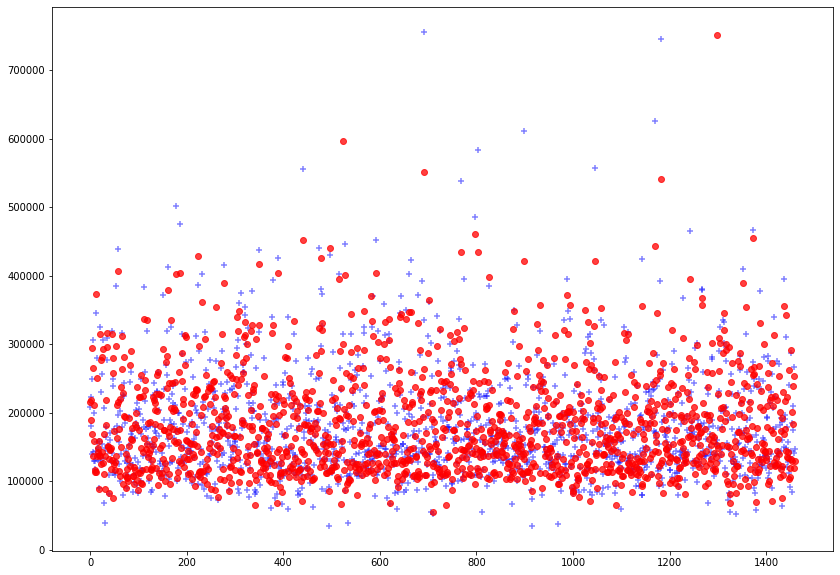

In [74]:
plt.figure(figsize=[14.0,10.0])
plt.scatter(axis,saleprice, marker='+', c='b', alpha=0.5)
plt.scatter(axis,test_predictions, marker='o',c='r', alpha=0.75)
plt.savefig('both_plot.svg')

Random Forest is:              $190196.00

KERAS Sequential is:           $156905.00

Linear Regression is:          $144265.00

Decision Tree Regression is:   $229387.00

Random Forest is:              $212979.00

KERAS Sequential is:           $237672.00

Linear Regression is:          $171429.00

Decision Tree Regression is:   $168135.00